In [1]:
import sys
sys.path.insert(0, 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\frxas.py')

import numpy as np
import h5py
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters, minimize, report_fit

from frxas import hdf5_io
from frxas import models
from frxas import visualization

%reload_ext autoreload
%autoreload 2

In [2]:
def chi_pattern(x, yd, ld, tg, kappa, gamma, amp, aoo, po2, po2_ref, f):
    r"""Summarize the function in one line.

    Function for dimensionless vacancy concentrations assuming ideal behavior
    and overpotential control.

    Parameters
    ----------
    x : list or np.ndarray
        Array or list of arrays of length values.
    ld : float
        :math:`l_{\delta}` : Characteristic length scale of vacancy profile,
        often called the "utilization length".
    tg : float
        :math:`t_G`  : Characteristic time scale of vacancy profile. Reflects
        time scale of switching from kinetic limitations (low frequency) to
        co-limitation by kinetics and diffusion (moderate to high frequency).
    ao : float
        :math:`A_o` : Thermodynamic factor.
    kappa : float
        Bleh bleah
    gamma : float
        Bleh bleah
    f : float
        Applied linear frequency in units of Hz.

    Returns
    -------
    np.ndarray
        Evaluated function for given length array and parameters.
    """
    k = kappa
    g = gamma

    ao = models.calc_ao(aoo, po2, po2_ref)

    chi = -amp / (ao + ao * g * np.sqrt(2 * 10**k * (1 + 1j * tg * 2 * np.pi * f))) \
    * np.exp(-(x +yd) / ld * np.sqrt(1 + 1j * tg * 2 * np.pi * f))

    return chi

In [4]:
f1 = hdf5_io.get_all_datasets('July18_frXAS_v2', start_indices = [[5, 2, 3], [5, 6, 0], [1, 3]])
hdf5_io.close_frxas_file('July18_frXAS_v2')

In [5]:
x, data, frequencies = hdf5_io.unpack_data(f1, kind='data_adj')

In [44]:
x[5] = x[5]+2.5

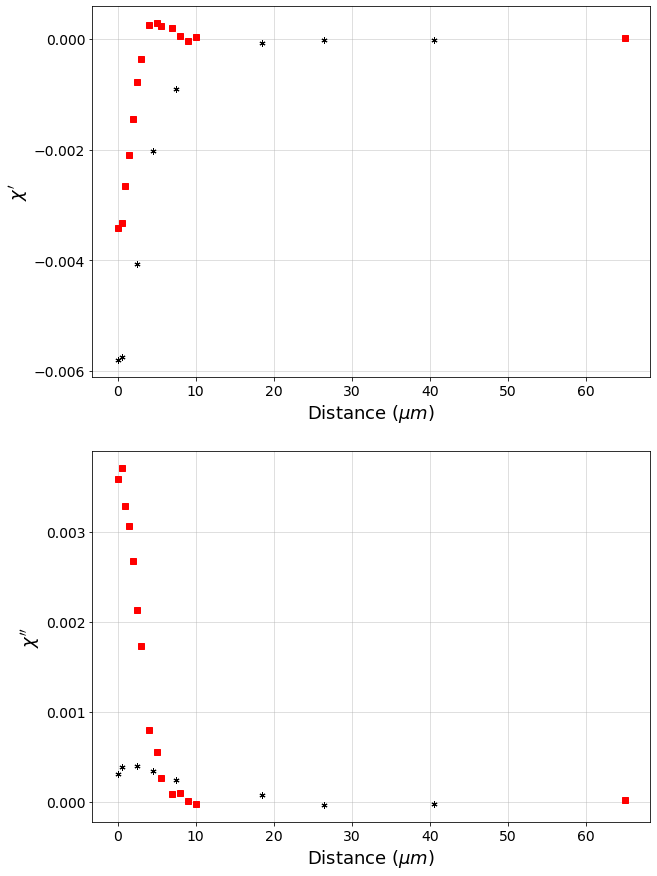

In [7]:
fig, axes = plt.subplots(nrows=2, figsize=(10,15))

# visualization.plot_chi(axes, x[:3], data[:3])
# axes = visualization.plot_chi(axes, x[3:6], data[3:6])
axes = visualization.plot_chi(axes, x[6:], data[6:])
# axes[1].set_xlim((420, 460))
plt.show()

In [8]:
fit_params = Parameters()

for iy, y in enumerate(data):
    fit_params.add('yd_%i' % (iy+1), value=0, min=0.0, max=5, vary=False)
    fit_params.add('ld_%i' % (iy+1), value=15, min=0.0, max=200)
    fit_params.add('tg_%i' % (iy+1), value=.1, min=0.01, max=100.0)
    fit_params.add('kappa_%i' % (iy+1), value=-3, min=-8, max=1)
    fit_params.add('gamma_%i' % (iy+1), value=1, min=0, max=10)
    fit_params.add('amp_%i' % (iy+1), value=.002, min=0, max=1)
    fit_params.add('aoo_%i' % (iy+1), value=1.5, min=1, max=5)
    fit_params.add('po2_%i' % (iy+1), value=0.01, vary=False)
    fit_params.add('po2_ref_%i' % (iy+1), value=1, vary=False)
    fit_params.add('f_%i' % (iy+1), value=frequencies[iy], vary=False)
        
for iy in np.arange(3,6):
    fit_params.add('po2_%i' % (iy+1), value=0.1, vary=False)
    fit_params['aoo_%i' % (iy+1)].expr = 'aoo_1'
for iy in np.arange(6,8):
    fit_params.add('po2_%i' % (iy+1), value=1, vary=False)
    fit_params['aoo_%i' % (iy+1)].expr = 'aoo_1'

In [9]:
for iy in np.arange(2, 4):
    fit_params['ld_%i' % iy].expr = 'ld_1'
    fit_params['tg_%i' % iy].expr = 'tg_1'
    fit_params['kappa_%i' % iy].expr = 'kappa_1'
    fit_params['gamma_%i' % iy].expr = 'gamma_1'
    fit_params['amp_%i' % iy].expr = 'amp_1'
    fit_params['aoo_%i' % iy].expr = 'aoo_1'

for iy in np.arange(5, 7):
    fit_params['ld_%i' % iy].expr = 'ld_4'
    fit_params['tg_%i' % iy].expr = 'tg_4'
    fit_params['kappa_%i' % iy].expr = 'kappa_4'
    fit_params['gamma_%i' % iy].expr = 'gamma_4'
    fit_params['amp_%i' % iy].expr = 'amp_4'
    fit_params['aoo_%i' % iy].expr = 'aoo_1'

for iy in np.arange(8, 9):
    fit_params['ld_%i' % iy].expr = 'ld_7'
    fit_params['tg_%i' % iy].expr = 'tg_7'
    fit_params['kappa_%i' % iy].expr = 'kappa_7'
    fit_params['gamma_%i' % iy].expr = 'gamma_7'
    fit_params['amp_%i' % iy].expr = 'amp_7'
    fit_params['aoo_%i' % iy].expr = 'aoo_1'

In [10]:
mini =lmfit.Minimizer(models.objective_fun, fit_params, fcn_args=(x, data, chi_pattern), nan_policy='propagate')

In [14]:
out = mini.minimize(method='leastsq')
report_fit(out.params)

[[Variables]]
    yd_1:       0 (fixed)
    ld_1:       19.5006128 +/- 1.34634935 (6.90%) (init = 15)
    tg_1:       0.86115641 +/- 0.12613056 (14.65%) (init = 0.1)
    kappa_1:   -1.89434306 +/- 873000.992 (46084630.02%) (init = -3)
    gamma_1:    0.57070916 +/- 573608.156 (100507962.95%) (init = 1)
    amp_1:      0.01431564 +/- 181.616105 (1268655.01%) (init = 0.002)
    aoo_1:      1.00000013 +/- 1268.62272 (126862.25%) (init = 1.5)
    po2_1:      0.01 (fixed)
    po2_ref_1:  1 (fixed)
    f_1:        0.25 (fixed)
    yd_2:       0 (fixed)
    ld_2:       19.5006128 +/- 1.34679330 (6.91%) == 'ld_1'
    tg_2:       0.86115641 +/- 0.12089532 (14.04%) == 'tg_1'
    kappa_2:   -1.89434306 +/- 873000.992 (46084630.02%) == 'kappa_1'
    gamma_2:    0.57070916 +/- 573608.156 (100507963.03%) == 'gamma_1'
    amp_2:      0.01431564 +/- 181.616105 (1268655.01%) == 'amp_1'
    aoo_2:      1.00000013 +/- 1268.62272 (126862.25%) == 'aoo_1'
    po2_2:      0.01 (fixed)
    po2_ref_2:  1 (fixe

In [118]:
ci = lmfit.conf_interval(mini, out1, sigmas=[1, 2])
lmfit.printfuncs.report_ci(ci)

C:\Users\shadd\Anaconda3\lib\site-packages\lmfit-0.9.13-py3.6.egg\lmfit\confidence.py:318: UserWarning: rel_change=-1.0 < 1e-05 at iteration 2 and prob(kappa_1=-2.6520802884555) = 0.0 < max(sigmas).
  warn(errmsg)
C:\Users\shadd\Anaconda3\lib\site-packages\lmfit-0.9.13-py3.6.egg\lmfit\confidence.py:318: UserWarning: rel_change=-1.0 < 1e-05 at iteration 2 and prob(kappa_1=-1.1366058379095003) = 0.0 < max(sigmas).
  warn(errmsg)
C:\Users\shadd\Anaconda3\lib\site-packages\lmfit-0.9.13-py3.6.egg\lmfit\confidence.py:318: UserWarning: rel_change=-1.0 < 1e-05 at iteration 2 and prob(gamma_1=0.3424254988162614) = 0.0 < max(sigmas).
  warn(errmsg)
C:\Users\shadd\Anaconda3\lib\site-packages\lmfit-0.9.13-py3.6.egg\lmfit\confidence.py:318: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(gamma_1=0.6848509976325228) = 0.0 < max(sigmas).
  warn(errmsg)
C:\Users\shadd\Anaconda3\lib\site-packages\lmfit-0.9.13-py3.6.egg\lmfit\confidence.py:318: UserWarning: rel_change=0.0 < 1e-05 at iteratio

            95.45%    68.27%    _BEST_    68.27%    95.45%
 ld_1   :  -2.84897  -1.51312  19.50061  +1.76482  +3.90311
 tg_1   :  -0.25484  -0.14052   0.86116  +0.17855  +0.41595
 kappa_1:      -inf      -inf  -1.89434      +inf      +inf
 gamma_1:      -inf      -inf   0.57071      +inf      +inf
 amp_1  :  -0.00068  -0.00035   0.01432      +inf      +inf
 aoo_1  :      -inf      -inf   1.00000  +0.40000  +0.39995
 ld_4   :  -1.35344  -0.70297  12.47290  +0.76971  +1.62574
 tg_4   :  -0.11641  -0.06208   0.48250  +0.07205  +0.15729
 kappa_4:  -0.34201  -0.17107  -3.51430      +inf      +inf
 gamma_4:      -inf      -inf   9.99289      +inf      +inf
 amp_4  :  -0.00121  -0.00065   0.01381      +inf      +inf
 ld_7   :  -0.62576  -0.32793   3.75429  +0.26224  +0.54343
 tg_7   :  -0.00610  -0.00318   0.04182  +0.00904  +0.02920
 kappa_7:  -0.08713  -0.11331   1.00000      +inf      +inf
 gamma_7:  -0.69778  -0.35935  10.00000      +inf      +inf
 amp_7  :  -0.30873  -0.28744   0.32548  

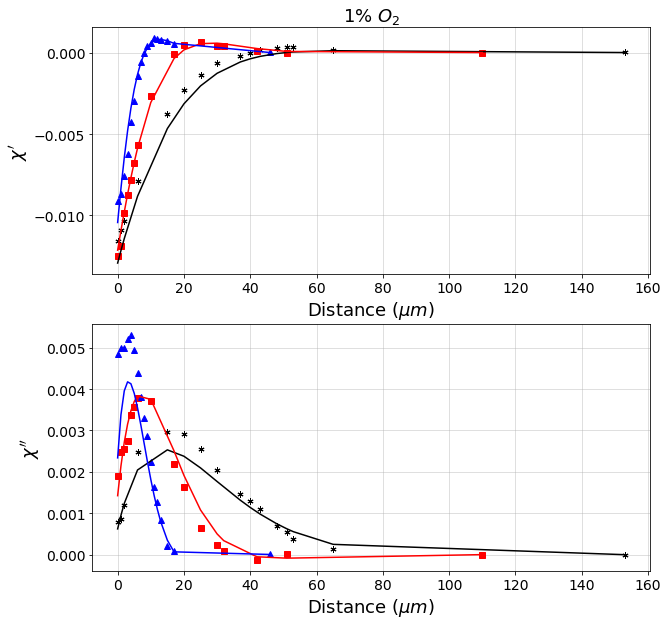

In [15]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(0,3):
    visualization.plot_chi(axes, x[iy], data[iy], ls='')
for iy in np.arange(0,3):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], chi_pattern), marker='')
    
axes[0].set_title('1% $O_2$', fontsize=18)
plt.show()

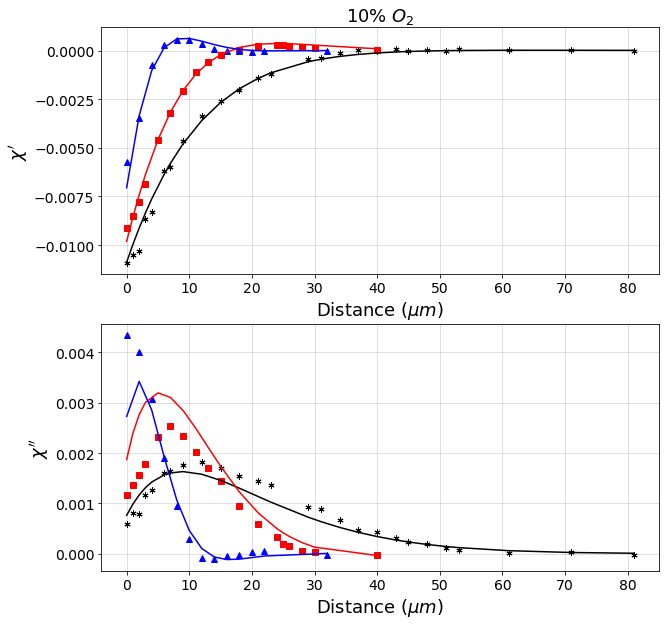

In [16]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(3,6):
    visualization.plot_chi(axes, x[iy], data[iy], ls='')
for iy in np.arange(3,6):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], chi_pattern), marker='')
    
axes[0].set_title('10% $O_2$', fontsize=18)
plt.show()

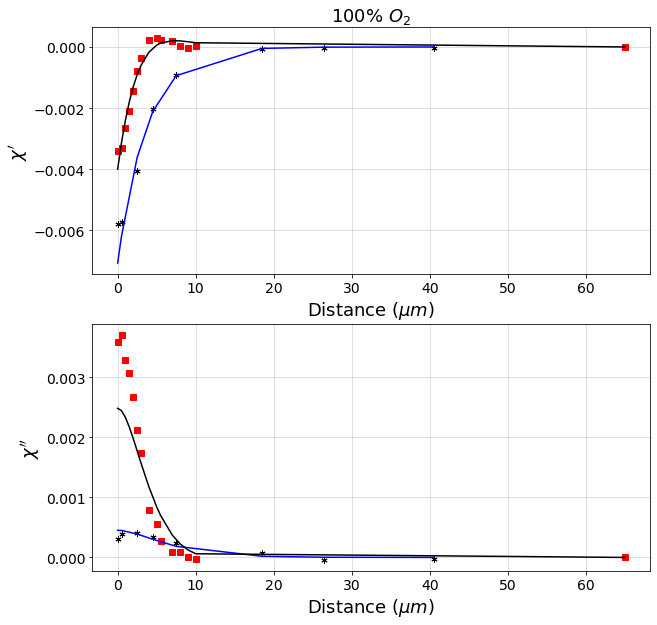

In [17]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(6,8):
    visualization.plot_chi(axes, x[iy], data[iy], ls='')
for iy in np.arange(6,8):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], chi_pattern), marker='')
    
axes[0].set_title('100% $O_2$', fontsize=18)
plt.show()

Data clearly not fitting to the patterned model. Seemingly occurs because the real data isn't scaled to 1 (max values for real components are ~0.002)